# Titanic Dataset Kernel

This notebook is intended for anyone to get a beginner-friendly walkthrough of how they can proceed with the Titanic dataset. I have tried to use Scikit learn as much as possible, the intent is to make a sk-learn pipeline in future commits. 

I do not explain the code in this notebook and the intended audience for this notebook are folks who have Python knowledge but looking to get started on ML.

One of the reasons I am creating this kernel is because I noticed that Kaggle has a lot of kernels which show the completed product, but couldn't find one which takes you through the journey on how steps such as feature engineering and grid search will be able to help a data scientist along the way

This is my first published kernel on Kaggle and I will be glad to receive comments. If you have any suggestions on how this notebook can be improved, please let me know.

## Table of Contents

1. [Import statements](#Import-statements)
2. [Exploratory-Data-Analysis(EDA)](#Exploratory-Data-Analysis(EDA))
3. [Imputing & Cleaning](#Imputing-&-Cleaning)
4. [Modelling](#Modelling)

### Import statements

Lets start out by importing all required libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

Lets disable warnings so that we can keep this notebook clean

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('./titanic_data/train.csv')
test_df = pd.read_csv('./titanic_data/test.csv')
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_df.shape

(891, 12)

In [5]:
test_df.shape

(418, 11)

In [6]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Exploratory Data Analysis(EDA)

In [7]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train_df['Cabin'].nunique()

147

Compared to the fact that we have 890 rows of data, 150 unique values is very high and might not lead to much of an improvement in our modelling process, let's drop this later

In [9]:
train_df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [10]:
train_df['Embarked'].nunique()

3

The *Embarked* attribute only has 3 unique values, so let's keep this feature in our dataset

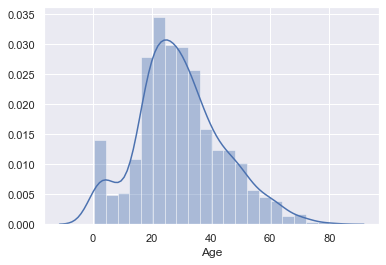

In [11]:
sns.distplot(train_df['Age'].dropna())

### Imputing & Cleaning

In this section, we are going to clean the data by removing unnecessary features and imputing values for missing data

In [12]:
train_df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], inplace=True, axis=1)
train_df = train_df[train_df.Embarked.notna()]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [13]:
passengerList = test_df['PassengerId']
test_df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], inplace=True, axis=1)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [14]:
X = train_df.loc[:, train_df.columns != 'Survived']
y = train_df.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y)

As we saw in the distribution plot above, *Age* is a skewed feature. To impute skewed features, we usually use the Median of that feature. If it was not skewed, then we would be using the Mean of the feature in most cases.

In [15]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train['Age'].to_numpy().reshape(-1, 1))

X_train['Age'] = imputer.transform(X_train['Age'].to_numpy().reshape(-1, 1))
X_test['Age'] = imputer.transform(X_test['Age'].to_numpy().reshape(-1, 1))

test_df['Age'] = imputer.transform(test_df['Age'].to_numpy().reshape(-1, 1))

In [16]:
X_train['Age'] = X_train['Age'].round()
X_test['Age'] = X_test['Age'].round()

X_train['Fare'] = X_train['Fare'].round()
X_test['Fare'] = X_test['Fare'].round()

test_df['Age'] = test_df['Age'].round()
test_df['Fare'] = test_df['Age'].round()

The *pd.get_dummies* is used to split out the categorical variables and performs [One-Hot Encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) on the data. 

In [17]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
test_df = pd.get_dummies(test_df)

### Modelling

I feel that our data is now in a good position for us to go ahead and create models out of. Lets start by using Random Forest.

**Note:** When you run the below cell block, you will get a different accuracy and that's completely alright. Your dataset will be split in a different way and I am not using random state here to get unified results as I would like the reader to execute these and learn how these accuracies differ with the steps we perform

In [18]:
gridParameters = {'n_estimators': [1, 5, 10, 50, 100],
                 'max_depth': [None, 1, 5, 10, 50, 100]}

model = RandomForestClassifier()
clf = GridSearchCV(model, gridParameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [19]:
accuracy_score(y_test, y_pred)

0.8161434977578476

**This solution has given me an accuracy of 81.1% on the validation set. Submitting it on Kaggle gives me an accuracy of 77.99%**

We are now going to train multiple classification algorithms on the same dataset and then extract the classifier that provided the best accuracy metrics

#### Multiple Classifiers

In [64]:
#Function to run different classifications algorithms. Returns the clf object of the classifier that gave highest accuracy

def getBestClassifier(X_train, y_train, X_test, y_test):    
    classifierList = {
        'SVM': SVC(),
        'Neural Network': MLPClassifier(),
        'Random Forest': RandomForestClassifier()
    }

    classifierParams = {
        'SVM': {'C': [0.01, 0.1, 1, 10, 100],
               'kernel': ['linear', 'rbf', 'sigmoid']},
        'Neural Network': {'activation': ['identity', 'logistic', 'tanh', 'relu']},
        'Random Forest': {'n_estimators': [1, 5, 10, 50, 100],
                     'max_depth': [None, 1, 5, 10, 50, 100]}
    }
    
    fittedClassifiersParam = {}
    
    for key, classifier in classifierList.items():
        clf = GridSearchCV(classifier, classifierParams[key])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        fittedClassifiersParam[key] = [accuracy_score(y_test, y_pred), clf.best_estimator_]
        print('Accuracy of {0:20s}: {1}'.format(key, str(accuracy_score(y_test, y_pred))))
    
    return fittedClassifiersParam[sorted(fittedClassifiersParam, key = lambda k : fittedClassifiersParam[k][0], reverse=True)[0]]

In [63]:
#Used to plot a confusion matrix

def confusionMatrix(y_test, y_pred):
    fig, ax = plt.subplots()
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, annot = True, fmt='d')

    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    ax.set_ylim([0, 2])

In [22]:
bestClassifier = getBestClassifier(X_train, y_train, X_test, y_test)

SVM                  has accuracy: 0.7623318385650224
Neural Network       has accuracy: 0.7802690582959642
Random Forest        has accuracy: 0.820627802690583


In [23]:
bestClassifier

[0.820627802690583,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False)]

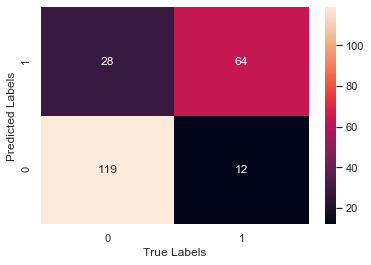

In [24]:
confusionMatrix(y_test, bestClassifier[1].predict(X_test))

**Even after performing a grid search, the best model that we have is Random Forest which is spitting out an accuracy of 79.4%. Lets try and analyze what went wrong by looking at the feature importances of the features**

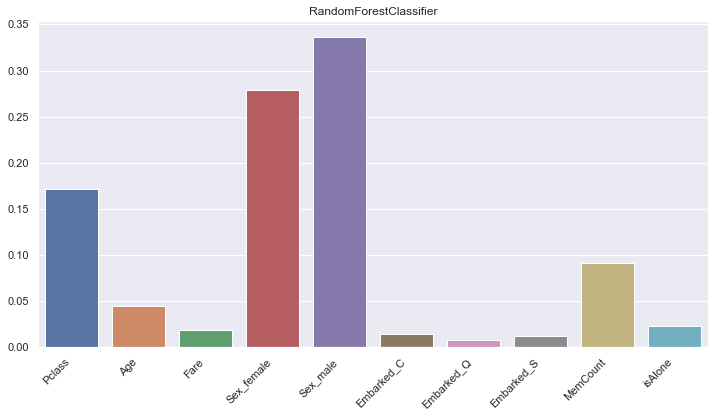

In [31]:
if bestClassifier[1].__class__.__name__ == 'MLPClassifier':
    print("Feature Importance not available for the model chosen: " + str(bestClassifier[1].__class__.__name__) )
else:
    plt.figure(figsize =(12, 6))
    plt.title(bestClassifier[1].__class__.__name__)
    sns.barplot(x=X_train.columns, y=bestClassifier[1].feature_importances_)
    plt.xticks(rotation=45, horizontalalignment='right')

In [26]:
X_train['MemCount'] =  X_train['SibSp'] + X_train['Parch']
X_test['MemCount'] =  X_test['SibSp'] + X_test['Parch']
test_df['MemCount'] =  test_df['SibSp'] + test_df['Parch']

X_train.drop(['SibSp', 'Parch'], inplace=True, axis=1)
X_test.drop(['SibSp', 'Parch'], inplace=True, axis=1)
test_df.drop(['SibSp', 'Parch'], inplace=True, axis=1)

X_train['isAlone'] = X_train['MemCount'].apply(lambda x: 1 if x > 0 else 0)
X_test['isAlone'] = X_test['MemCount'].apply(lambda x: 1 if x > 0 else 0)
test_df['isAlone'] = test_df['MemCount'].apply(lambda x: 1 if x > 0 else 0)

X_train['Age'] = pd.cut(X_train['Age'], 4, labels=[1, 2, 3, 4])
X_test['Age'] = pd.cut(X_test['Age'], 4, labels=[1, 2, 3, 4])
test_df['Age'] = pd.cut(test_df['Age'], 4, labels=[1, 2, 3, 4])

X_train['Fare'] = pd.cut(X_train['Fare'], 4, labels=[1, 2, 3, 4])
X_test['Fare'] = pd.cut(X_test['Fare'], 4, labels=[1, 2, 3, 4])
test_df['Fare'] = pd.cut(test_df['Fare'], 4, labels=[1, 2, 3, 4])

In [27]:
X_train['Age'] = X_train['Age'].astype('int')
X_train['Fare'] = X_train['Fare'].astype('int')

X_test['Age'] = X_test['Age'].astype('int')
X_test['Fare'] = X_test['Fare'].astype('int')

test_df['Fare'] = test_df['Fare'].astype('int')
test_df['Age'] = test_df['Age'].astype('int')

In [28]:
bestClassifier = getBestClassifier(X_train, y_train, X_test, y_test)

SVM                  has accuracy: 0.7892376681614349
Neural Network       has accuracy: 0.7802690582959642
Random Forest        has accuracy: 0.8116591928251121


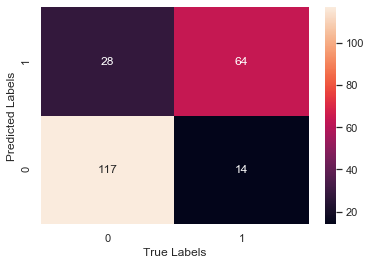

In [29]:
confusionMatrix(y_test, bestClassifier[1].predict(X_test))

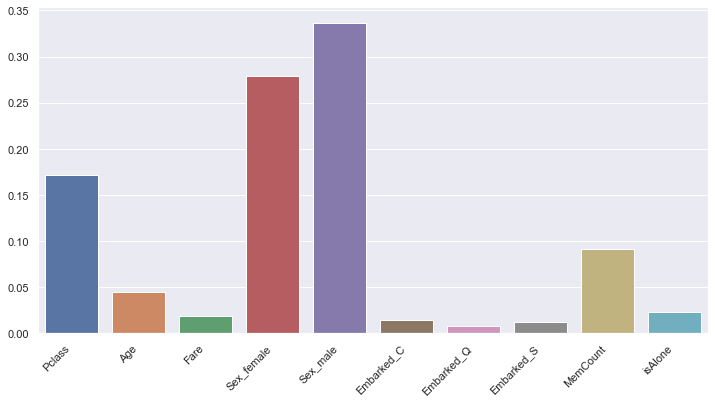

In [30]:
if bestClassifier[1].__class__.__name__ == 'MLPClassifier':
    print("Feature Importance not available for the model chosen: " + str(bestClassifier[1].__class__.__name__) )
else:
    plt.figure(figsize =(12, 6))
    sns.barplot(x=X_train.columns, y=bestClassifier[1].feature_importances_)
    plt.xticks(rotation=45, horizontalalignment='right')

**The feature engineering steps have increased my score from 77.99% to 78.5%, a marginal increase over our previous solutions**

To try increase the accuracy, we are going to bring about the following changes:

* In the feature engineering side, let's bring back the name column and use only the title of the names. Using the name column will give us access to a plethora of new indirect information such as the status of the person
* In the modelling side, we are going to bring use a few gradient boosted algorithms, namely, XGBoost, Catboost & LightGBM. We are then going to create an ensemble which will comprise of Neural Networks and Gradient Boosted trees

To bring back the title column, we have to read the information again and then extract the titles from the *Name* column

In [42]:
titleTrainDf = pd.read_csv('./titanic_data/train.csv')
titleTestDf = pd.read_csv('./titanic_data/test.csv')

In [43]:
titleTrainDf = titleTrainDf.filter(['Name'])
titleTestDf = titleTestDf.filter(['Name'])

In [44]:
trainTitleSeries = titleTrainDf['Name'].str.split(", ").apply(lambda x: x[1]).str.split(".").apply(lambda x : x[0])
trainTitleSeries = trainTitleSeries.rename('Title')

testTitleSeries = titleTestDf['Name'].str.split(", ").apply(lambda x: x[1]).str.split(".").apply(lambda x : x[0])
testTitleSeries = testTitleSeries.rename('Title')

In [45]:
trainTitleSeries.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Sir               1
Lady              1
Don               1
the Countess      1
Jonkheer          1
Ms                1
Capt              1
Mme               1
Name: Title, dtype: int64

As we can see above, a lot of Titles occur only once in the dataset. Let us group them all into a title called *Rare*

In [65]:
# Function to map the names to appropriate titles

def classifyTitles(x):
    return 'Rare' if x not in ['Mr', 'Miss', 'Mrs', 'Master'] else x

In [47]:
trainTitleSeries = trainTitleSeries.apply(classifyTitles)
testTitleSeries = testTitleSeries.apply(classifyTitles)

In [49]:
X_train = X_train.merge(trainTitleSeries, left_index=True, right_index=True)
X_test = X_test.merge(trainTitleSeries, left_index=True, right_index=True)

test_df = test_df.merge(testTitleSeries, left_index=True, right_index=True)

In [51]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
test_df = pd.get_dummies(test_df)

In [52]:
classifierList = {
    'SVM': SVC(),
    'Neural Network': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(silent=1, verbose_eval=False),
    'CatBoost': CatBoostClassifier(logging_level='Silent'),
    'LightGBM': lgb.LGBMClassifier()
}

gridEstimatorCount = [1, 5, 10, 50, 100]
gridMaxDepth = [1, 2, 4, 5, 8, 10]
gridLearningRate = [0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

classifierParams = {
    'SVM': {'C': [0.01, 0.1, 1, 10, 100],
           'kernel': ['linear', 'rbf', 'sigmoid']},
    'Neural Network': {'activation': ['identity', 'logistic', 'tanh', 'relu']},
    'Random Forest': {'n_estimators': gridEstimatorCount,
                 'max_depth': gridMaxDepth},
    'XGBoost': {'learning_rate': gridLearningRate, 
            'max_depth': gridMaxDepth, 
            'n_estimators': gridEstimatorCount},
    'CatBoost': {'n_estimators': gridEstimatorCount,
                'max_depth': gridMaxDepth},
    'LightGBM': {'n_estimators': gridEstimatorCount,
                'max_depth': gridMaxDepth}
}

In [53]:
def createEnsemble(X_train, y_train, X_test=[], y_test=[], classifierList={}, isFullDataset=False):        
    fittedClassifiers = {}
    
    if not classifierList:
        return
    
    for key, classifier in classifierList.items():
        
        print("Now training: ", key)
        
        clf = GridSearchCV(classifier, classifierParams[key], cv=5, n_jobs=-1, scoring='accuracy')
        clf.fit(X_train, y_train)
        fittedClassifiers.update({key: clf.best_estimator_})

        if not isFullDataset:
            y_pred = clf.predict(X_test)
            print(key + ' has accuracy: ' + str(accuracy_score(y_test, y_pred)))
    
    ensemble = VotingClassifier(estimators=[(k, v) for k, v in fittedClassifiers.items()])
    return ensemble

Lets create an ensemble with Neural Network, LightGBM and Random Forest

In [54]:
classifierList = {
    'Neural Network': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

In [55]:
bestClassifier = createEnsemble(X_train, y_train, X_test, y_test, classifierList=classifierList)

Now training:  Neural Network
Neural Network has accuracy: 0.8026905829596412
Now training:  Random Forest
Random Forest has accuracy: 0.8071748878923767
Now training:  LightGBM
LightGBM has accuracy: 0.8116591928251121


**Running model on the entire dataset. This will be submitted for prediction**

In [57]:
finalTrainingDataset = pd.concat([X_train, X_test])
finalTargetDataset = pd.concat([y_train, y_test])

ensemble = createEnsemble(finalTrainingDataset, finalTargetDataset, classifierList=classifierList, isFullDataset=True)

results = ensemble.fit(finalTrainingDataset, finalTargetDataset).predict(test_df)

Now training:  Neural Network
Now training:  Random Forest
Now training:  LightGBM


**Creating CSV for submission:**

In [60]:
pd.concat([passengerList, pd.Series(results, name='Survived')], axis=1).to_csv('080620_final_ensemble.csv', index=False)